In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab 
from datetime import datetime, timedelta
import numpy as np

In [2]:
data = pd.read_csv(r'./charge_hourly_with_Covid_new.csv')

In [3]:
data

,Time,Energy_kWh,weekday,hour,hols,is_hol,measure,E_1,E_2,E_3
0,2020-12-02 09:00:00,4.214567,2,10,NaN,False,3.0,NaN,NaN,NaN
1,2020-12-02 10:00:00,0.560625,2,11,NaN,False,3.0,4.214567,NaN,NaN
2,2020-12-02 11:00:00,0.000000,2,12,NaN,False,3.0,0.560625,4.214567,NaN
3,2020-12-02 12:00:00,0.000000,2,13,NaN,False,3.0,0.000000,0.560625,4.214567
4,2020-12-02 13:00:00,0.000558,2,14,NaN,False,3.0,0.000000,0.000000,0.560625
...,...,...,...,...,...,...,...,...,...,...
10883,2022-02-28 20:00:00,0.000000,0,21,Spring holiday,True,0.0,0.000000,0.000000,0.000925
10884,2022-02-28 21:00:00,0.000000,0,22,Spring holiday,True,0.0,0.000000,0.000000,0.000000
10885,2022-02-28 22:00:00,0.000000,0,23,Spring holiday,True,0.0,0.000000,0.000000,0.000000
10886,2022-02-28 23:00:00,0.000000,1,0,Spring holiday,True,0.0,0.000000,0.000000,0.000000


In [4]:
patMon = data[data.weekday == 0].groupby(['hour']).mean()
patMon.reset_index(inplace=True)
patTue = data[data.weekday == 1].groupby(['hour']).mean()
patTue.reset_index(inplace=True)
patWed = data[data.weekday == 2].groupby(['hour']).mean()
patWed.reset_index(inplace=True)
patThu = data[data.weekday == 3].groupby(['hour']).mean()
patThu.reset_index(inplace=True)
patFri = data[data.weekday == 4].groupby(['hour']).mean()
patFri.reset_index(inplace=True)
patSat = data[data.weekday == 5].groupby(['hour']).mean()
patSat.reset_index(inplace=True)
patSun = data[data.weekday == 6].groupby(['hour']).mean()
patSun.reset_index(inplace=True)

In [5]:
patWeek_Avg = pd.concat([patMon, patTue, patWed, patThu, patFri, patSat, patSun])
patWeek_Avg.reset_index(inplace=True)

In [6]:
patWeek_Avg.drop(['index'], axis=1, inplace=True)

<AxesSubplot:>

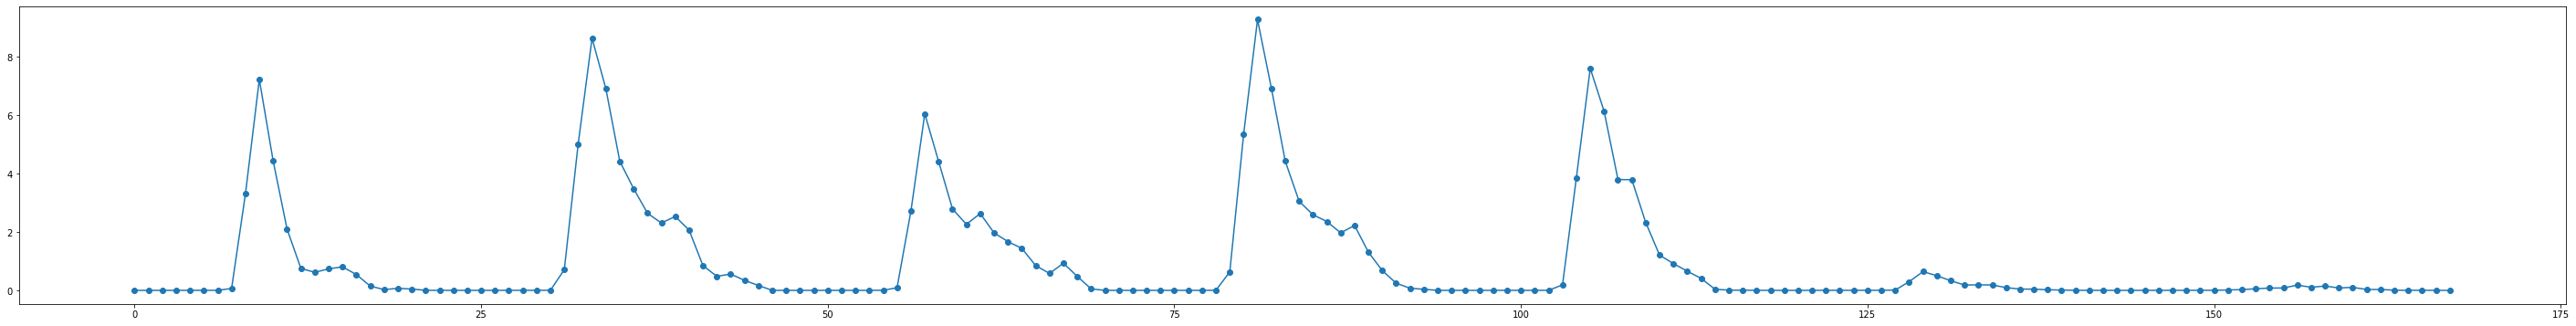

In [7]:
patWeek_Avg['Energy_kWh'].plot(figsize=(50,6), marker='o')

In [8]:
patWeek_Avg.drop(['is_hol','measure','E_1','E_2','E_3'], axis=1, inplace=True)
patWeek_Avg

,hour,Energy_kWh,weekday
0,0,0.000000,0.0
1,1,0.000000,0.0
2,2,0.000000,0.0
3,3,0.000000,0.0
4,4,0.000000,0.0
...,...,...,...
163,19,0.005972,6.0
164,20,0.002017,6.0
165,21,0.003842,6.0
166,22,0.000000,6.0


In [9]:
def Predict5h(df_in):
    predictions = np.zeros(shape=(len(df_in)-5, 5))
    targets = np.zeros(shape=(len(df_in)-5, 5))
    Els = df_in['Energy_kWh']
    max_index = len(patWeek_Avg)
    for i in range(len(df_in)-5):
        weekday = df_in.weekday[i]
        hour = df_in.hour[i]
        index = patWeek_Avg[(patWeek_Avg.weekday == weekday) & (patWeek_Avg.hour == hour)]['Energy_kWh'].index[0]
        targets[i] = [Els[i+1], Els[i+2], Els[i+3], Els[i+4], Els[i+5]]
        diff = Els[i] - patWeek_Avg.Energy_kWh[index]
        predictions[i] = [diff + patWeek_Avg.Energy_kWh[(index+1)%max_index],diff + patWeek_Avg.Energy_kWh[(index+2)%max_index],diff + patWeek_Avg.Energy_kWh[(index+3)%max_index],diff + patWeek_Avg.Energy_kWh[(index+4)%max_index],diff + patWeek_Avg.Energy_kWh[(index+5)%max_index]]
    return targets, predictions

In [10]:
targs, preds = Predict5h(data)

In [11]:
targs.shape

(10883, 5)

In [12]:
preds.shape

(10883, 5)

In [13]:
import torch.nn.functional as F

# Custom loss for multi-point forecasting

def multiPointLoss(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = F.mse_loss(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = torch.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = torch.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score

In [14]:
import torch

multiPointLoss(torch.tensor(targs), torch.tensor(preds))

tensor(3.1367, dtype=torch.float64)

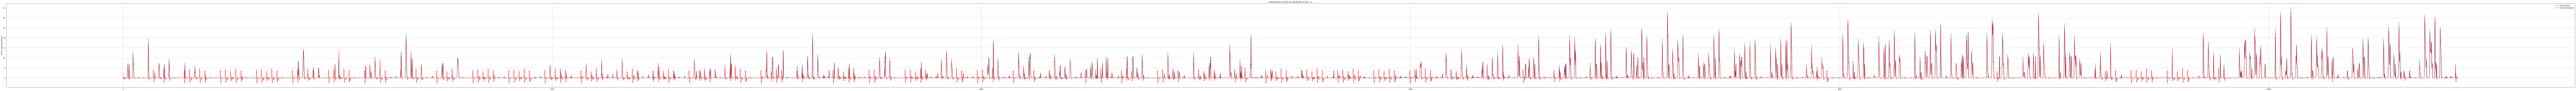

In [15]:
plt.figure(figsize=(300,10))
plt.plot(range(len(targs)), targs[:,0])
plt.plot(range(len(preds)), preds[:,0], 'r')
plt.title('Performance on test set, prediction of hour +1')
plt.ylabel('Hourly charging demand')
plt.legend(['Real demand', 'Predicted demand'])
plt.grid()
plt.show()

# Test data

In [16]:
test_data = pd.read_csv(r'./charge0422_hourly_with_Covid_new.csv')

In [17]:
targs, preds = Predict5h(test_data)

In [18]:
multiPointLoss(torch.tensor(targs), torch.tensor(preds))

tensor(4.9583, dtype=torch.float64)

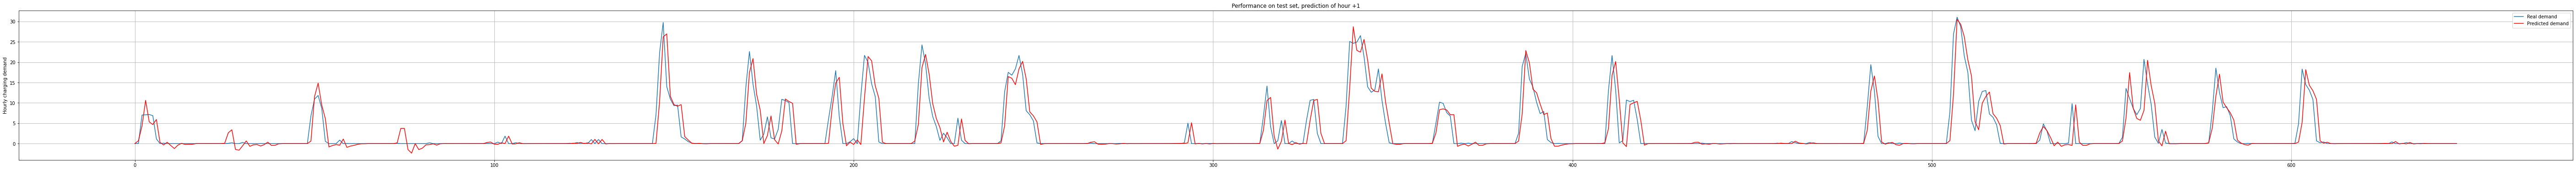

In [19]:
plt.figure(figsize=(100,6))
plt.plot(range(len(targs)), targs[:,0])
plt.plot(range(len(preds)), preds[:,0], 'r')
plt.title('Performance on test set, prediction of hour +1')
plt.ylabel('Hourly charging demand')
plt.legend(['Real demand', 'Predicted demand'])
plt.grid()
plt.show()

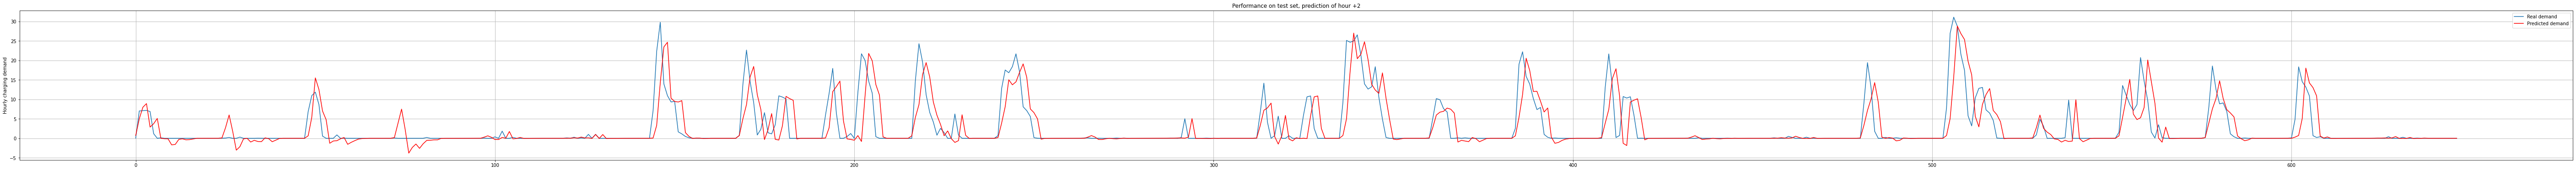

In [20]:
plt.figure(figsize=(100,6))
plt.plot(range(len(targs)), targs[:,1])
plt.plot(range(len(preds)), preds[:,1], 'r')
plt.title('Performance on test set, prediction of hour +2')
plt.ylabel('Hourly charging demand')
plt.legend(['Real demand', 'Predicted demand'])
plt.grid()
plt.show()

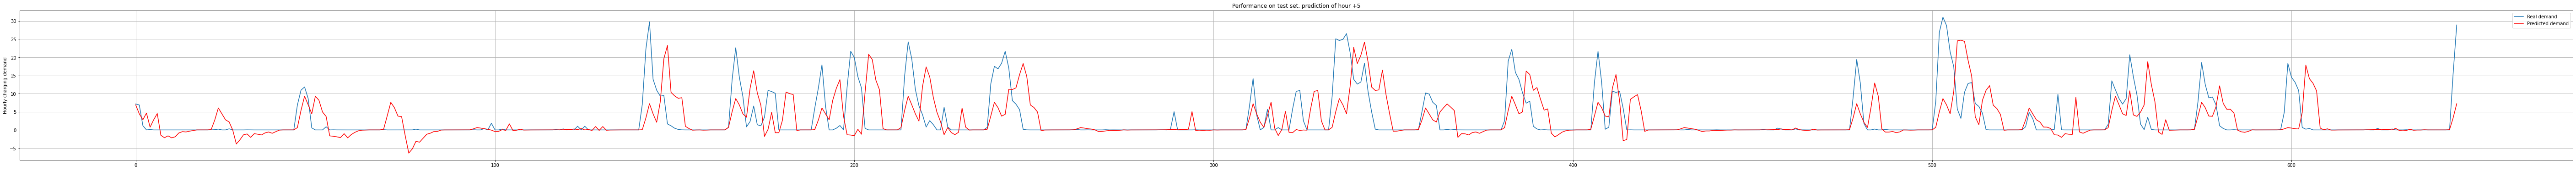

In [21]:
plt.figure(figsize=(100,6))
plt.plot(range(len(targs)), targs[:,4])
plt.plot(range(len(preds)), preds[:,4], 'r')
plt.title('Performance on test set, prediction of hour +5')
plt.ylabel('Hourly charging demand')
plt.legend(['Real demand', 'Predicted demand'])
plt.grid()
plt.show()

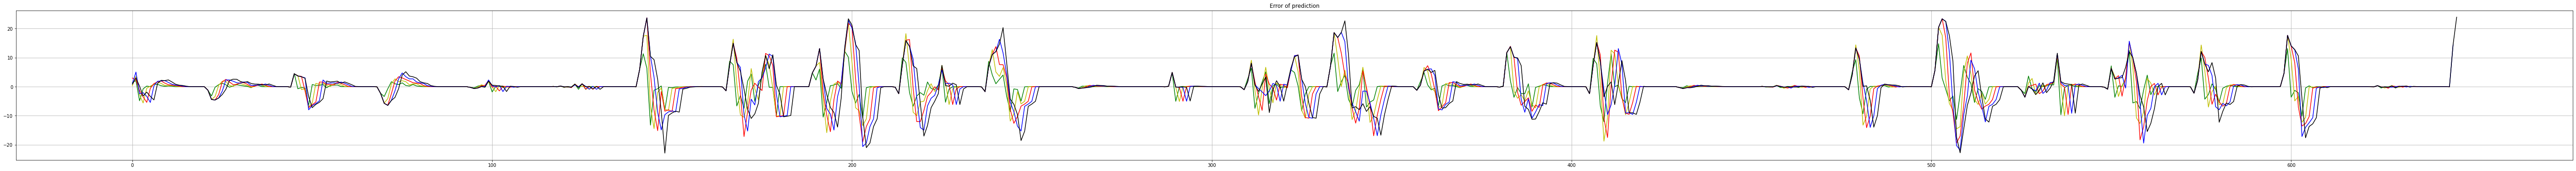

In [62]:
plt.figure(figsize=(100,6))
plt.plot(range(len(preds)-4), targs[4:,0] - preds[4:,0], 'g')
plt.plot(range(len(preds)-3), targs[3:,1] - preds[3:,1], 'y')
plt.plot(range(len(preds)-2), targs[2:,2] - preds[2:,2], 'r')
plt.plot(range(len(preds)-1), targs[1:,3] - preds[1:,3], 'b')
plt.plot(range(len(preds)), targs[:,4] - preds[:,4], 'k')
plt.title('Error of prediction')
plt.grid()
plt.show()